<a href="https://colab.research.google.com/github/THANNAGA/Lagrangian/blob/main/logistic_regression_lagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

!pip install git+https://github.com/cooper-org/cooper.git
import cooper
from copy import deepcopy as copy

  Cloning https://github.com/cooper-org/cooper.git to /tmp/pip-req-build-b04rpd_g
  Running command git clone --filter=blob:none --quiet https://github.com/cooper-org/cooper.git /tmp/pip-req-build-b04rpd_g
  Resolved https://github.com/cooper-org/cooper.git to commit eae7c5a68563b83410913c8b24e99b70e32694f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cooper: filename=cooper-0.1.dev8+geae7c5a-py3-none-any.whl size=22101 sha256=2f1ffb1bb200b5b3bda67d1e1bf7a34a5365f07f276d8beca8e97c35d60dfce4
  Stored in directory: /tmp/pip-ephem-wheel-cache-imgqqz3y/wheels/17/2a/69/d1383f8d416e79d1943da9a72deb9c295d6a2988fceabc9f9d
Successfully built cooper


In [3]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.input_dim = input_dim
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        outputs = self.linear(x)
        return outputs


class NormConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to have norm less than or equal to 1
        # g(W) <= 1  ---> g(W) - 1 <= 0
        ineq_defect = model.linear.weight.norm(dim=1) - 1

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class NormConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to have norm less than or equal to 1
        # g(W) <= 1  ---> g(W) - 1 <= 0
        ineq_defect = model.linear.weight.norm(dim=1) - 1

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

In [4]:
dataset = MNIST(os.getcwd() + "/data", download=True, transform=transforms.ToTensor())
train_set, val_set = random_split(dataset, [55000, 5000])

100%|██████████| 9912422/9912422 [00:00<00:00, 95692498.58it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31488352.96it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25989625.77it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3375957.61it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [5]:
cmp = NormConstrainedLogReg()
formulation = cooper.LagrangianFormulation(cmp)

model = LogisticRegression(784, 10)

# primal_optimizer = cooper.optim.ExtraSGD(model.parameters(), lr=1e-3, momentum=0.9)
# dual_optimizer = cooper.optim.partial_optimizer(cooper.optim.ExtraSGD, lr=5e-3)

primal_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
dual_optimizer = cooper.optim.partial_optimizer(torch.optim.SGD, lr=5e-3)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [6]:
iter_num = 0

state_history = OrderedDict()

for epoch in range(3):
    for inputs, targets in DataLoader(train_set, batch_size=64):

        coop.zero_grad()
        lagrangian = formulation.composite_objective(
            cmp.closure, model, inputs, targets
        )
        formulation.custom_backward(lagrangian)
        coop.step(cmp.closure, model, inputs, targets)

        if iter_num % 5 == 0:
            state_history[iter_num] = {
                "cmp": cmp.state,
                "dual": copy(formulation.state()),
            }

        iter_num += 1

In [7]:
iters, loss_history = zip(
    *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
)
mult_hist = np.stack(
    [_["dual"][0].data.numpy() for (foo, _) in state_history.items()], axis=1
)
defect_hist = np.stack(
    [_["cmp"].ineq_defect.data.numpy() for (foo, _) in state_history.items()], axis=1
)

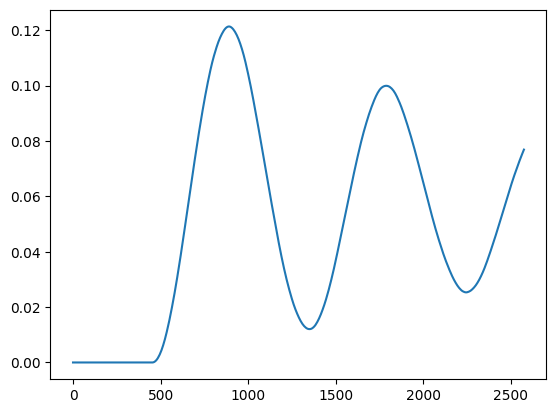

In [8]:
plt.plot(iters, mult_hist[0:1, ...].T)
plt.show()

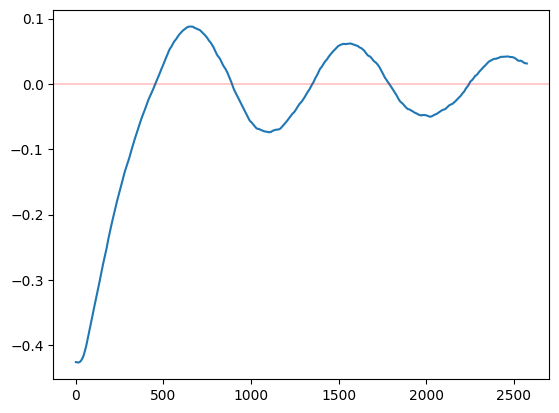

In [9]:
plt.plot(iters, defect_hist[0:1, ...].T)
plt.axhline(0.0, c="r", alpha=0.2)
plt.show()

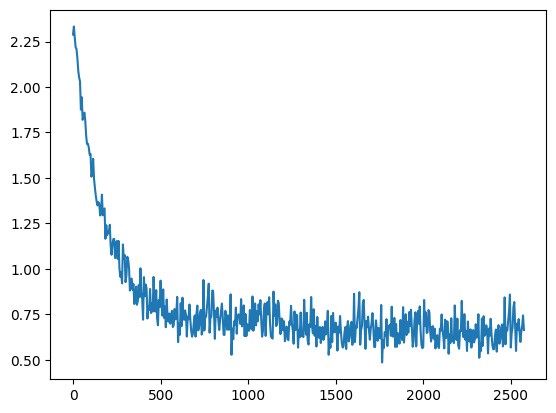

In [10]:
plt.plot(iters, loss_history)

In [11]:
total, correct = 0, 0
with torch.no_grad():
    for inputs, targets in DataLoader(val_set, batch_size=64):
        outputs = model.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum()
accuracy = 100 * correct / total

In [ ]:
accuracy

tensor(87.2600)